In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.metrics import AUC as auc

<h3>Setup</h3>

<h3>PreProcessing</h3>

In [2]:
from core import preprocessing

test data location = D:\DL\tf-image-classifier\chest_xray/test
training data location = D:\DL\tf-image-classifier\chest_xray/train
validation data location = D:\DL\tf-image-classifier\chest_xray/val


In [3]:
data_dir = preprocessing.root_data_dir
test_path = preprocessing.test_path
train_path = preprocessing.train_path
val_path = preprocessing.validation_path

image_shape = (300, 300, 3)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
image_gen = ImageDataGenerator(fill_mode='nearest')
image_gen.flow_from_directory(train_path)
image_gen.flow_from_directory(test_path)
image_gen.flow_from_directory(val_path)

Found 15504 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


<h2>Building a Model</h2>

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Layer, concatenate, GlobalAveragePooling2D,Activation, Softmax
from tensorflow.keras.metrics import Accuracy, AUC, Recall, Precision

In [7]:
class fire_module(Layer):
    
    def __init__(self, squeeze_size=16, expand_size=64):
        super(fire_module, self).__init__()
        self.squeeze = Conv2D(filters=squeeze_size, kernel_size=(1,1), padding='valid', \
                              activation='relu', name="sq1x1")
        self.exp1_1 = Conv2D(filters=expand_size, kernel_size=(1,1), padding='valid', \
                             activation='relu', name="exp1x1")
        self.exp3_3 = Conv2D(filters=expand_size, kernel_size=(3,3), padding='same', \
                             activation='relu', name="exp3x3")
    
    def call(self, input):
        squeezed_value = self.squeeze(input)
        exp1_1_value = self.exp1_1(squeezed_value)
        exp3_3_value = self.exp3_3(squeezed_value)
        return concatenate([exp1_1_value, exp3_3_value], axis=-1, name='concat')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'squeeze': self.squeeze,
            'exp1_1': self.exp1_1,
            'exp3_3': self.exp3_3
        })
        return config

In [8]:
def build_model(expand_values, pooling_kernal):
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
    
    for expand_value in expand_values:
        model.add(fire_module(int((3*expand_value)/4),expand_value))
        model.add(MaxPool2D(pool_size=pooling_kernal))
    
    model.add(Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid'))
    model.add(GlobalAveragePooling2D())

    model.compile(loss=loss_param, optimizer=optimizer_param,
                metrics=[AUC()])
    return model

In [9]:
loss_param = 'binary_crossentropy'
optimizer_param = 'adam'
stop_monitor = 'val_auc'
stop_mode = 'max'
stop_patience = 2

<h2>Regularization</h2>

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import normalize

In [11]:
def regularize(batch_size):
    data = {}
    data['early_stop'] = EarlyStopping(monitor=stop_monitor, mode=stop_mode, patience=stop_patience)
    data['train_image_gen'] = image_gen.flow_from_directory(train_path,
                                               target_size = image_shape[:2],
                                               batch_size = batch_size,
                                               class_mode = 'binary')
    data['test_image_gen'] = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               batch_size = batch_size,
                                               class_mode='binary',
                                               shuffle=False)# Don't want to shuffle test data and lose labels
    return data

<h2>Recording</h2>

In [12]:
def create_record(model, batch_size):
    losses = model.history.history
    losses['loss'] = np.asarray(losses['loss'])
    losses['val_loss'] = np.asarray(losses['val_loss'])
    final_number_of_epochs = len(losses['loss'])
    min_loss = losses['loss'].min()
    mean_loss = losses['loss'].mean()
    final_loss = losses['loss'][-1]
    min_val_loss = losses['val_loss'].min()
    mean_val_loss = losses['val_loss'].mean()
    final_val_loss = losses['val_loss'][-1]

    output = []
    model.summary(print_fn=lambda line: output.append(line))
    summary = str(output).strip('[]')

    record = {
        'Epochs': final_number_of_epochs,
        'Batch_Size': batch_size,
        'Loss_Func': loss_param,
        'Optimizer': optimizer_param,
        'Early_Stop_Monitor': stop_monitor,
        'Early_Stop_Patience': stop_patience,
        'Min_Loss': min_loss,
        'Mean_Loss': mean_loss,
        'Final_Loss': final_loss,
        'Min_Val_Loss': min_val_loss,
        'Mean_Val_Loss': mean_val_loss,
        'Final_Val_Loss': final_val_loss,
        'Model': summary
    }

    new_data = pd.DataFrame(record, index=[0])

    if os.path.exists('results.csv'):
        df_records = pd.read_csv('results.csv')
        df_records = df_records.append(new_data)
    else:
        df_records = pd.DataFrame(new_data)

    df_records.to_csv('results.csv', float_format='%g')

<h2>Running the Model</h2>

In [13]:
def run_test(expand_values, pooling_kernel, batch_size):
    model = build_model(expand_values, pooling_kernel)
    data = regularize(batch_size)
    return model, model.fit(data['train_image_gen'], epochs=20,
                             validation_data=data['test_image_gen'],
                    callbacks=[data['early_stop']]
                   )

In [ ]:
#done
'''
Dont run yet 
TODO: make run_test take in data to work on so this test can work with un processed data
'''
batch_size = 64
model, results = run_test([8],(4,4),batch_size)
print(model.summary)
create_record(model,batch_size)

metrics = pd.DataFrame(model.history.history)
metrics.plot()
metrics[['auc', 'val_auc']].plot()

model.save('model1.h5')#change this for every test

Found 15504 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Train for 243 steps, validate for 10 steps
Epoch 1/20
243/243 [==============================] - 1070s 4s/step - loss: 0.6400 - auc: 0.7582 - val_loss: 0.5742 - val_auc: 0.7910
Epoch 2/20
243/243 [==============================] - 1109s 5s/step - loss: 0.5094 - auc: 0.8847 - val_loss: 0.5571 - val_auc: 0.8458
Epoch 3/20
243/243 [==============================] - 1088s 4s/step - loss: 0.4077 - auc: 0.9460 - val_loss: 0.4814 - val_auc: 0.8548
Epoch 4/20
243/243 [==============================] - 1059s 4s/step - loss: 0.3622 - auc: 0.9557 - val_loss: 0.4638 - val_auc: 0.8596
Epoch 5/20
243/243 [==============================] - 1105s 5s/step - loss: 0.3425 - auc: 0.9562 - val_loss: 0.4481 - val_auc: 0.8640
Epoch 6/20
243/243 [==============================] - 1115s 5s/step - loss: 0.3304 - auc: 0.9574 - val_loss: 0.4399 - val_auc: 0.8691
Epoch 7/20
243/243 [==============================] - 1115s 5s/step -

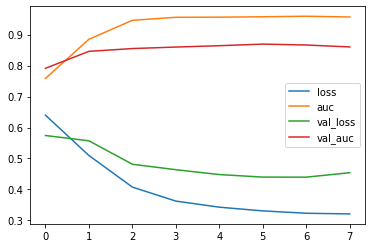

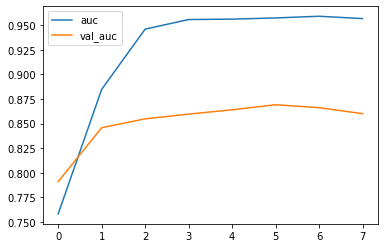

In [15]:
#done
batch_size = 64
model, results = run_test([8,16],(3,3),batch_size)
create_record(model,batch_size)

metrics = pd.DataFrame(model.history.history)
metrics.plot()
metrics[['auc', 'val_auc']].plot()

model.save('model2.h5')#change this for every test

Found 15504 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Train for 243 steps, validate for 10 steps
Epoch 1/20
243/243 [==============================] - 1091s 4s/step - loss: 0.5474 - auc: 0.8361 - val_loss: 0.5136 - val_auc: 0.8491
Epoch 2/20
243/243 [==============================] - 1084s 4s/step - loss: 0.3718 - auc: 0.9382 - val_loss: 0.4577 - val_auc: 0.8776
Epoch 3/20
243/243 [==============================] - 1097s 5s/step - loss: 0.3114 - auc: 0.9523 - val_loss: 0.4314 - val_auc: 0.8856
Epoch 4/20
243/243 [==============================] - 1115s 5s/step - loss: 0.2965 - auc: 0.9545 - val_loss: 0.4445 - val_auc: 0.8835
Epoch 5/20
243/243 [==============================] - 1091s 4s/step - loss: 0.2823 - auc: 0.9597 - val_loss: 0.4171 - val_auc: 0.8919
Epoch 6/20
243/243 [==============================] - 1073s 4s/step - loss: 0.2738 - auc: 0.9622 - val_loss: 0.5099 - val_auc: 0.8882
Epoch 7/20
243/243 [==============================] - 1109s 5s/step -

TypeError: can't pickle _thread._local objects

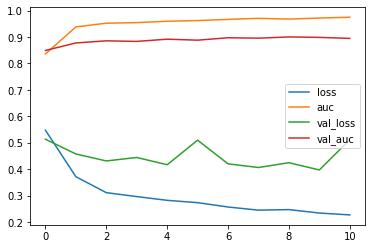

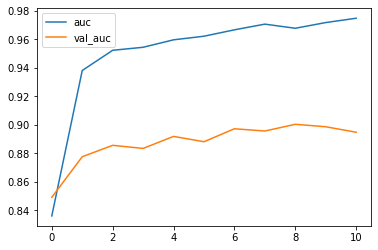

In [14]:
#done

batch_size = 64
model, results = run_test([8,16,24],(3,3),batch_size)
print(model.summary)
create_record(model,batch_size)

metrics = pd.DataFrame(model.history.history)
metrics.plot()
metrics[['auc', 'val_auc']].plot()

model.save('model3.h5')#change this for every test

Found 15504 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Train for 243 steps, validate for 10 steps
Epoch 1/20
243/243 [==============================] - 1101s 5s/step - loss: 0.4548 - auc: 0.8823 - val_loss: 0.6230 - val_auc: 0.8749
Epoch 2/20
243/243 [==============================] - 1115s 5s/step - loss: 0.2605 - auc: 0.9638 - val_loss: 0.4024 - val_auc: 0.9061
Epoch 3/20
243/243 [==============================] - 1115s 5s/step - loss: 0.2078 - auc: 0.9794 - val_loss: 0.3732 - val_auc: 0.9151
Epoch 4/20
243/243 [==============================] - 1150s 5s/step - loss: 0.1807 - auc: 0.9845 - val_loss: 0.6715 - val_auc: 0.8900
Epoch 5/20
243/243 [==============================] - 1121s 5s/step - loss: 0.1587 - auc: 0.9886 - val_loss: 0.5043 - val_auc: 0.9024


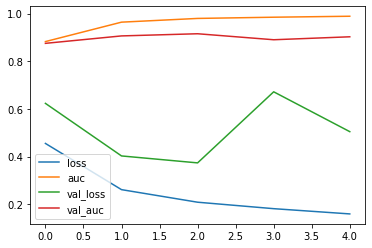

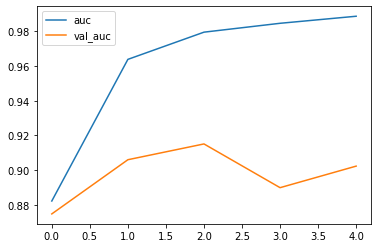

In [14]:
#done
batch_size = 64
model, results = run_test([8,16,24,32],(3,3),batch_size)
print(model.summary)
create_record(model,batch_size)

metrics = pd.DataFrame(model.history.history)
metrics.plot()
metrics[['auc', 'val_auc']].plot()

#model.save('image_classifier_auc_4layer_batch64.h5')#change this for every test

In [ ]:
#done
batch_size = 32
model = run_test([8,16,24],(3,3),batch_size)
print(model.summary)
create_record(model,batch_size)

metrics = pd.DataFrame(model.history.history)
metrics.plot()
metrics[['auc', 'val_auc']].plot()

model.save('model5.h5')#change this for every test

Found 15504 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Train for 485 steps, validate for 20 steps
Epoch 1/20
485/485 [==============================] - 1156s 2s/step - loss: 0.3984 - auc: 0.9125 - val_loss: 0.4610 - val_auc: 0.8848
Epoch 2/20
485/485 [==============================] - 1107s 2s/step - loss: 0.2410 - auc: 0.9709 - val_loss: 0.4292 - val_auc: 0.9014
Epoch 3/20
485/485 [==============================] - 1118s 2s/step - loss: 0.2150 - auc: 0.9769 - val_loss: 0.5826 - val_auc: 0.8824
Epoch 4/20
485/485 [==============================] - 1150s 2s/step - loss: 0.1926 - auc: 0.9814 - val_loss: 0.4707 - val_auc: 0.9038
Epoch 5/20
485/485 [==============================] - 1122s 2s/step - loss: 0.1590 - auc: 0.9878 - val_loss: 0.6137 - val_auc: 0.8997
Epoch 6/20
485/485 [==============================] - 1136s 2s/step - loss: 0.1558 - auc: 0.9883 - val_loss: 0.7526 - val_auc: 0.8948


TypeError: can't pickle _thread._local objects

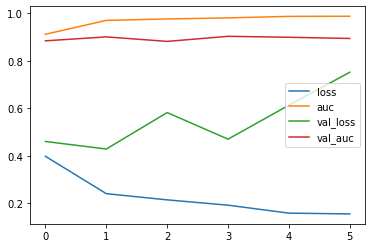

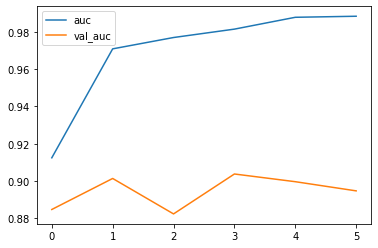

In [14]:
#done
batch_size = 32
model, results = run_test([8,16,24,32],(3,3),batch_size)
create_record(model,batch_size)

metrics = pd.DataFrame(model.history.history)
metrics.plot()
metrics[['auc', 'val_auc']].plot()

model.save('model6.h5')#change this for every test

In [ ]:
#George
batch_size = 64
model = run_test([8,16,24],(2,2),batch_size)
print(model.summary)
create_record(model,batch_size)

metrics = pd.DataFrame(model.history.history)
metrics.plot()
metrics[['auc', 'val_auc']].plot()

model.save('model7.h5')#change this for every test

In [ ]:
#Kelsey
batch_size = 64
model = run_test([8,16,24,32],(2,2),batch_size)
print(model.summary)
create_record(model,batch_size)

metrics = pd.DataFrame(model.history.history)
metrics.plot()
metrics[['auc', 'val_auc']].plot()

model.save('model8.h5')#change this for every test

In [ ]:
#George
batch_size = 64
model = run_test([8,16,24,32,40],(2,2),batch_size)
print(model.summary)
create_record(model,batch_size)

metrics = pd.DataFrame(model.history.history)
metrics.plot()
metrics[['auc', 'val_auc']].plot()

model.save('model9.h5')#change this for every test